# Stepped solution

In [1]:
import pybamm
import matplotlib.pyplot as plt

In [2]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016()
solver = pybamm.ScikitsDaeSolver()
sim = pybamm.Simulation(model, solver=solver)

Final time 12000.0s


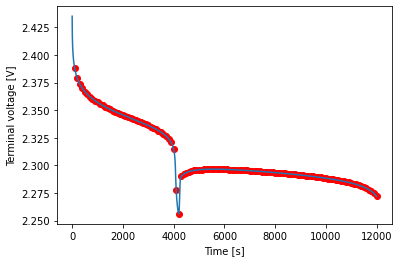

In [3]:
tstep = 100
npts = 100

error = False 

while error is False:
    try:
        solution = sim.step(tstep, npts=npts)
        t = solution.t
        V = solution["Terminal voltage [V]"].entries
        plt.plot(t[-1], V[-1], 'ro')
    except pybamm.SolverError:
        error = True
        t = solution.t
        V = solution["Terminal voltage [V]"].entries
        plt.plot(t, V)        
        plt.xlabel("Time [s]")
        plt.ylabel("Terminal voltage [V]")        
        print("Final time {}s".format(solution.t[-1]))

In [4]:
sim.plot(model.variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=3.3333333333333335, step=0.03333333333333333…

# Try at 1.7A (C/2) and reduce tstep after SolverError

In [5]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016()

# Update current 
param = model.default_parameter_values
param.update({"Current function [A]": 1.7})

# Update current and ICs to correspond to initial 2.4V as in ref [2]
param.update({    
    "Initial Condition for S8 ion [g]": 2.6730,
    "Initial Condition for S4 ion [g]": 0.0128,
    "Initial Condition for S2 ion [g]": 4.3321e-6,
    "Initial Condition for S ion [g]": 1.6321e-6,
    "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
    "Initial Condition for Terminal Voltage [V]": 2.4,
})

# Set up solver and simulation
solver = pybamm.ScikitsDaeSolver(atol=1e-6,rtol=1e-3)
sim = pybamm.Simulation(model, parameter_values=param, solver=solver)

Final time 7125.0s
Final discharge capacity 3.364583333333333 Ah


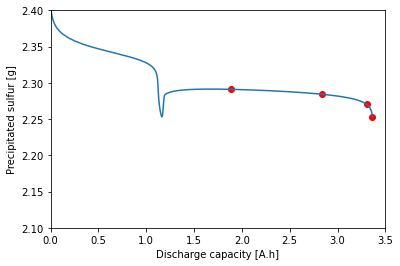

In [6]:
tstep = 4000  # going to fix npts = tpts, but not sure this is necessary  
tmin = 10  # minimum step 10s 

while tstep > tmin:
    try:
        solution = sim.step(tstep, npts=int(tstep))
        DC = solution["Discharge capacity [A.h]"].entries
        V = solution["Terminal voltage [V]"].entries
        plt.plot(DC[-1], V[-1], 'ro')
    except pybamm.SolverError:
        tstep = tstep/2
        
DC = solution["Discharge capacity [A.h]"].entries
V = solution["Terminal voltage [V]"].entries
S = solution["Precipitated Sulfur [g]"].entries

print("Final time {}s".format(solution.t[-1]))
print("Final discharge capacity {} Ah".format(DC[-1]))

plt.plot(DC, V)  
plt.xlim([0, 3.5])
plt.ylim([2.1, 2.4])
plt.xlabel("Discharge capacity [A.h]")
plt.ylabel("Precipitated sulfur [g]");

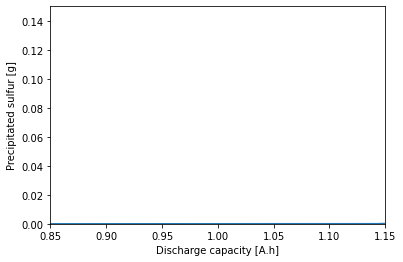

In [7]:
plt.plot(DC, S)  
plt.xlim([0.85, 1.15])
plt.ylim([0, 0.15])
plt.xlabel("Discharge capacity [A.h]")
plt.ylabel("Precipitated sulfur [g]");

In [8]:
sim.plot(model.variables, time_unit="seconds")

interactive(children=(FloatSlider(value=0.0, description='t', max=7125.0, step=71.25), Output()), _dom_classes…